## Ejercicio 2 - Serpientes y escalera

Resultados de la Simulación de Monte Carlo para cada casilla (num_simulaciones = 2000):
Para la casilla 1: el promedio de turnos es 40.34, con un intervalo de confianza del 95% entre [39.85, 40.83]
Para la casilla 2: el promedio de turnos es 39.90, con un intervalo de confianza del 95% entre [39.41, 40.39]
Para la casilla 3: el promedio de turnos es 39.86, con un intervalo de confianza del 95% entre [39.38, 40.34]
Para la casilla 4: el promedio de turnos es 40.50, con un intervalo de confianza del 95% entre [40.01, 40.98]
Para la casilla 5: el promedio de turnos es 39.91, con un intervalo de confianza del 95% entre [39.43, 40.39]
Para la casilla 6: el promedio de turnos es 39.31, con un intervalo de confianza del 95% entre [38.82, 39.80]
Para la casilla 7: el promedio de turnos es 39.87, con un intervalo de confianza del 95% entre [39.38, 40.36]
Para la casilla 8: el promedio de turnos es 39.12, con un intervalo de confianza del 95% entre [38.63, 39.62]
Para la casilla 9: el promedio d

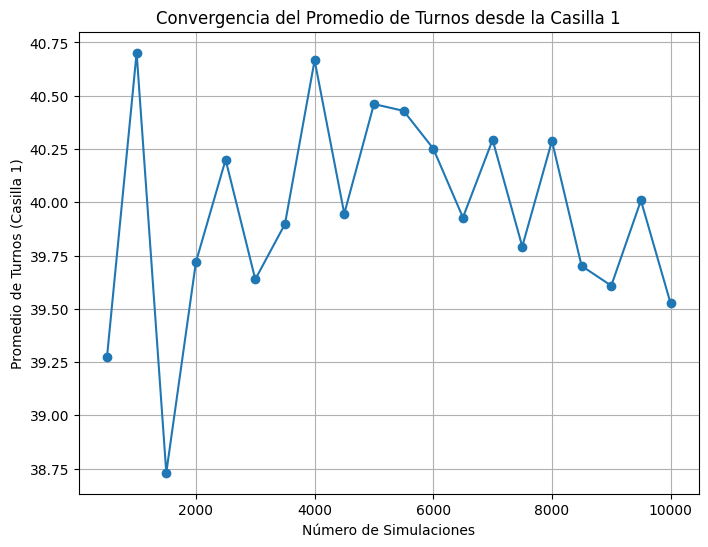

In [ ]:
import sys
import numpy as np
import random
from scipy.stats import norm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import matplotlib.pyplot as plt

# Determine the appropriate executor based on the environment
Executor = ThreadPoolExecutor if "ipykernel" in sys.modules else ProcessPoolExecutor

class Board:
    def __init__(self):
        self.squares = np.arange(101)
        self.ladders = {4: 56, 12: 50, 14: 55, 22: 58, 41: 79, 54: 88}
        self.snakes = {37: 3, 28: 10, 47: 16, 75: 32, 94: 71, 96: 42}
        self._setup_board()

    def _setup_board(self):
        for start, end in {**self.ladders, **self.snakes}.items():
            self.squares[start] = end

    def apply_rules(self, position):
        return self.squares[position]

class Game:
    def __init__(self, board):
        self.board = board

    def roll_dice(self):
        return random.randint(1, 6)

    def play(self, start_position):
        position = start_position
        turns = 0
        while position < 100:
            dice_roll = self.roll_dice()
            if position + dice_roll <= 100:
                position += dice_roll
                position = self.board.apply_rules(position)
            turns += 1
        return turns

def simulate_game(start_square, num_simulations, board):
    try:
        game = Game(board)
        turns_list = [game.play(start_square) for _ in range(num_simulations)]
        mean_turns = np.mean(turns_list)
        std_error = np.std(turns_list, ddof=1) / np.sqrt(num_simulations)

        confidence_interval = norm.interval(
            0.95,  # Confidence level
            loc=mean_turns,  # Mean
            scale=std_error  # Standard error
        )

        return start_square, {
            'mean_turns': mean_turns,
            'confidence_interval': confidence_interval
        }
    except Exception as e:
        print(f"Error al simular la casilla {start_square}: {e}")
        return start_square, None

def monte_carlo_simulation(board, num_simulations=10000):
    results = {}
    with Executor() as executor:
        futures = [executor.submit(simulate_game, square, num_simulations, board) for square in range(1, 100)]
        for future in futures:
            try:
                square, result = future.result()
                results[square] = result
            except Exception as e:
                print(f"Error al obtener el resultado para la casilla: {e}")
    return results

def plot_convergence(simulation_sizes, averages):
    plt.figure(figsize=(8, 6))
    plt.plot(simulation_sizes, averages, marker='o', linestyle='-')
    plt.xlabel("Número de Simulaciones")
    plt.ylabel("Promedio de Turnos (Casilla 1)")
    plt.title("Convergencia del Promedio de Turnos desde la Casilla 1")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    board = Board()

    # Full simulation for each square with maximum simulations
    max_simulations = 10000
    simulation_results = monte_carlo_simulation(board, num_simulations=max_simulations)

    print("Resultados de la Simulación de Monte Carlo para cada casilla (num_simulaciones ="+str(max_simulations)+"):")
    for square, stats in sorted(simulation_results.items()):
        if stats:
            print(f"Para la casilla {square}: el promedio de turnos es {stats['mean_turns']:.2f}, "
                  f"con un intervalo de confianza del 95% entre [{stats['confidence_interval'][0]:.2f}, {stats['confidence_interval'][1]:.2f}]")

    # Simulations for square 1 with varying numbers of simulations
    simulation_sizes = range(500, max_simulations + 1, 500)
    average_turns_square_1 = []

    for n in simulation_sizes:
        _, result = simulate_game(1, n, board)
        if result is not None:
            average_turns_square_1.append(result['mean_turns'])
        else:
            average_turns_square_1.append(np.nan)

    # Plot the convergence of average turns for square 1
    plot_convergence(simulation_sizes, average_turns_square_1)